# Алгоритмы с сжатием для задачи минимизации эмпирического риска

https://disk.yandex.ru/d/D3c1yIBEJgm8sw

## Постановка проблемы

Рассмотрим шаг градиентного спуска с оператором сжатия:
    
\begin{equation}
x^{k+1} := x^{k} - \eta \, \mathcal{C} \left(\nabla f \left(x^{k}\right) \right)
\label{problem}
\end{equation}

Здесь в качестве оператора сжатия $C$ можно взять разные функции:

    1. TopK   
Оставляет у аргумента K наибольших координат, остальное - зануляет

    2. RandK
Оставляет у аргумента K произвольных координат, остальное - зануляет

    3. Операторы, учитывающие важность каждой координаты
    
а) Рассмотрим
$$w_i := f \left(x^k \right) - f \left(x^k - \eta \left[ \nabla f(x^k) \right]_i \right)$$
Так мы можем оценить, насколько большое изменение мы можем сделать по каждой координате, и в результате спустимся только по $K$ "важным" координатам.

b) Рассмотрим вектор $w$ - решение оптимизационной задачи на симплексе
$$w := \arg\min_{\substack{w \in \Delta}} f \left(x^k - \eta \sum_{i=1}^d w_i \left[ \nabla f(x^k) \right]_i \right)$$
Таким образом, получим вектор $w$, характеризующий, насколько важна каждая из координат. Далее делаем спуск по $K$ наиболее важным координатам.

c) Аналогично, но вектор $w$ ищется из решения оптимизационной задачи
$$w := \arg\min_{\substack{w \in [0, 1]^d \\ \| w \|_0 \leq k}} f \left(x^k - \eta \sum_{i=1}^d w_i \left[ \nabla f(x^k) \right]_i \right)$$

## Реализация методов и анализ сходимости

Для начала рассмотрим первые 2 метода и убедимся, что они сходятся.

### Импорт библиотек, загрузка датасета и реализация кастомной логистической регрессии

In [97]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
# StandardScaler

In [98]:
dataset_path = "mushrooms.txt"
data = load_svmlight_file(dataset_path)

X = data[0].toarray()
y = data[1] * 2 - 3

trash = np.random.randn(X.shape[0], 1) * 100
X = np.hstack((X, trash))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [99]:
class MyLogisticRegression:
    def __init__(self, max_iter=500, learning_rate=None, lambda_=1):
        self.max_iter = max_iter
        self.lr = learning_rate
        self.lambda_ = lambda_

    
    def _sigmoid(self, z):
        return 1. / (1. + np.exp(-z))

    
    def _loss(self, w):
        margin = self.X @ w * self.y
        return np.mean(np.log2(1 + np.exp(-margin))) + self.lambda_ / 2 * np.linalg.norm(w) ** 2

    
    def _gradient(self, w):
        margin = self.X @ w * self.y
        margin_grad = self.X * self.y.reshape((self.X.shape[0], 1))
        return -1 / np.log(2) * self._sigmoid(-margin) @ margin_grad / self.X.shape[0] + self.lambda_ * w


    def _draw(self, yscale='log'):
        losses = []
        grads = []
        for w in self.w_history:
            losses.append(self._loss(w))
            grads.append(np.linalg.norm(self._gradient(w), 2) ** 2)

        plt.figure(figsize=(12, 6))
        plt.title('Loss function')
        plt.plot(losses, color='red')
        plt.xlabel('i')
        plt.ylabel('Loss')
        plt.yscale(yscale)
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.title('Gradient norm')
        plt.plot(grads, color='red')
        plt.xlabel('i')
        plt.ylabel('$\\| \\nabla f(w^i) \\|^2$')
        plt.yscale(yscale)
        plt.show()


    def _C(self, arr):
        return arr

    
    def fit(self, X, y, draw=False):
        if self.lr is None:   
            self.lr = 1. / (np.mean(np.linalg.norm(X, axis=1)**2) + self.lambda_)
            
        self.X = np.hstack((np.copy(X), np.ones((X.shape[0], 1))))
        self.y = np.copy(y)
        self.w = (self.y @ self.X) / np.linalg.norm(self.X, axis=0) ** 2
        self.w_history = [np.copy(self.w)]

        for k in range(self.max_iter):
            self.w = self.w - self.lr * self._C(self._gradient(self.w))
            self.w_history.append(np.copy(self.w))

        if draw:
            self._draw()

    
    def predict(self, X):
        return np.sign(np.hstack((X, np.ones((X.shape[0], 1)))) @ self.w)

    
    @property
    def coef_(self):
        return np.copy(self.w)[:-1]

    
    @property
    def intercept_(self):
        return np.copy(self.w)[-1]

    
    @property
    def coef_history_(self):
        return np.copy(self.w_history)

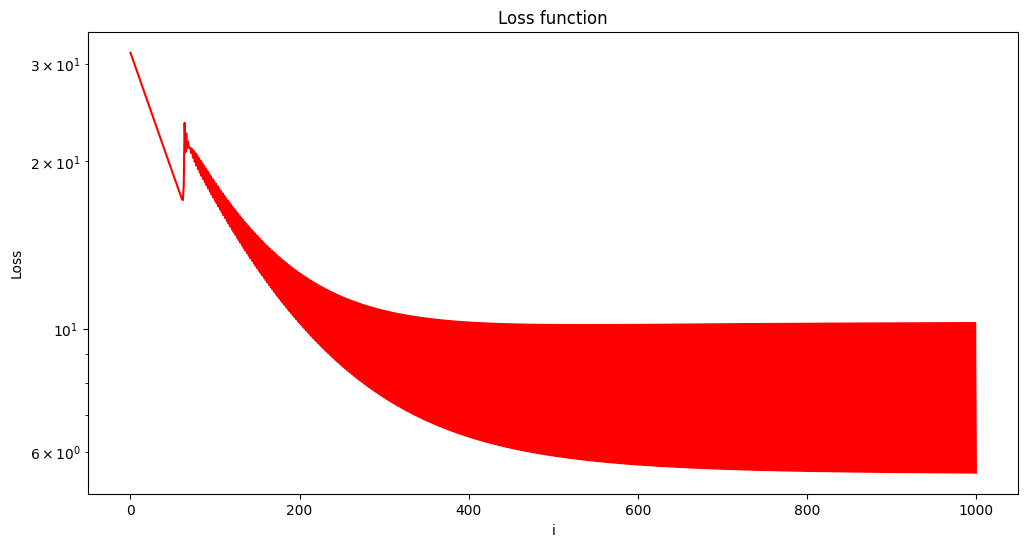

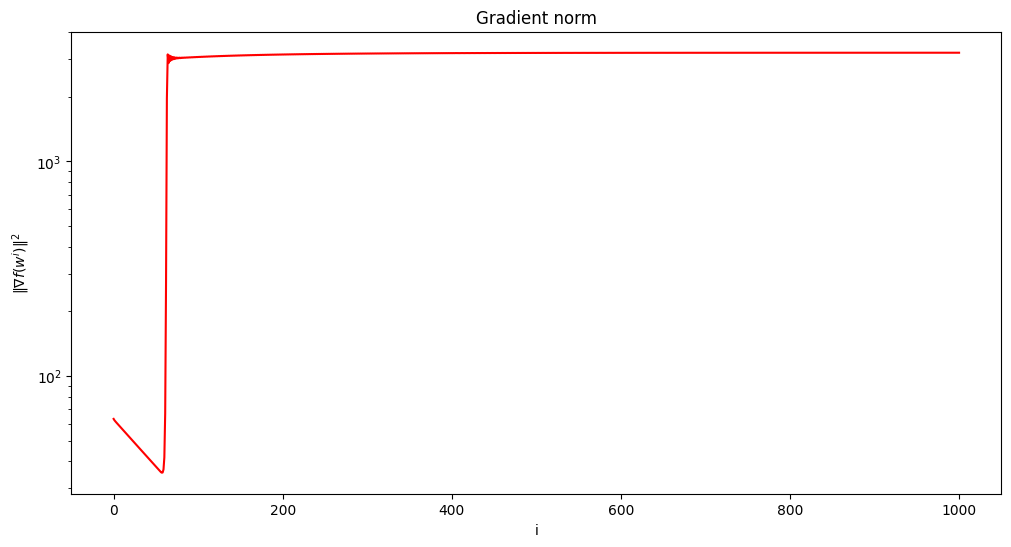

In [100]:
model = MyLogisticRegression(max_iter=1000, learning_rate=0.005)
model.fit(X_train, y_train, draw=True)
y_pred = model.predict(X_test)

In [101]:
print(f"Total labels: {y_test.shape[0]},\n\
Predicted correctly: {np.sum(y_test == y_pred)},\n\
Accuracy: {np.sum(y_test == y_pred) / y_test.shape[0]}")

Total labels: 1625,
Predicted correctly: 863,
Accuracy: 0.5310769230769231


In [103]:
model.coef_, model.intercept_

(array([-0.0069944 ,  0.03175351, -0.00104939, -0.03409939,  0.00938109,
         0.01614286, -0.02222689, -0.02959347, -0.00699227,  0.06565793,
         0.00455574, -0.00942073, -0.02263812,  0.01879   ,  0.01549003,
        -0.00399988,  0.00791427,  0.00818509,  0.03322999, -0.02608294,
         0.17026969, -0.15625501,  0.03877134, -0.02425755, -0.18671234,
        -0.009961  ,  0.03749652,  0.27533684, -0.0294739 , -0.05525832,
        -0.05396765,  0.01941673, -0.00154825, -0.0767078 ,  0.09379265,
         0.18193455, -0.17211178, -0.15142705,  0.01521076, -0.02316913,
        -0.02829194,  0.02572877,  0.01174517,  0.07232035,  0.01415442,
        -0.00884888,  0.03644018,  0.06050532,  0.00561521, -0.02836465,
         0.04103457,  0.00266751,  0.16545068, -0.17902657,  0.02547848,
         0.01253634,  0.14720263, -0.17266495,  0.02838371, -0.009961  ,
        -0.04219241,  0.01518187,  0.05281456,  0.02235414, -0.04011765,
        -0.0623304 ,  0.0768371 , -0.00741003, -0.0

### 0. Реализация известных методов с операторами сжатия Top-k и Rand-k

In [67]:
class MyLogisticRegression_TopK(MyLogisticRegression):
    def __init__(self, max_iter=3000, learning_rate=0.005, K=15):
        super().__init__(max_iter=max_iter, learning_rate=learning_rate)
        self.K = K

    
    def _C(self, arr):
        indices = np.argpartition(np.abs(arr), -self.K)[-self.K:]
        res = np.zeros_like(arr)
        res[indices] = arr[indices]
        return res


class MyLogisticRegression_RandK(MyLogisticRegression):
    def __init__(self, max_iter=3000, learning_rate=0.005, K=15):
        super().__init__(max_iter=max_iter, learning_rate=learning_rate)
        self.K = K

    
    def _C(self, arr):
        indices = np.random.randint(0, arr.shape[0], size=self.K)
        res = np.zeros_like(arr)
        res[indices] = arr[indices]
        return res

### 1. Реализация метода Best-k (a)

In [68]:
class MyLogisticRegression_BestK_a(MyLogisticRegression):
    def __init__(self, max_iter=3000, learning_rate=0.005, K=15):
        super().__init__(max_iter=max_iter, learning_rate=learning_rate)
        self.K = K

    
    def _C(self, arr):
        coord_gradients = np.diag(self._gradient(self.w))
        w_upd = self.w - self.lr * coord_gradients
        omega = np.zeros_like(self.w)
        for i in range(len(w_upd)):
            omega[i] = -1 * self._loss(w_upd[i])

        indices = np.argpartition(omega, -self.K)[-self.K:]
        res = np.zeros_like(arr)
        res[indices] = arr[indices]
        return res

### 2. Реализация метода Best-k (b)

На каждой итерации спуска нам нужно решать задачу:

$$\min_{\substack{w \in \Delta^d}} g_k(w),$$

где
$$g_k(w) := f \left(x^k - \eta \, w^T \cdot \mathcal{P} \right),$$
$$\mathcal{P} := \mathcal{I} \odot \nabla f\left(x^k \right) =
    \begin{pmatrix}
           \left[\nabla f\left(x^k \right)\right]_1, \left[\nabla f\left(x^k \right)\right]_2, ..., \left[\nabla f\left(x^k \right)\right]_d
     \end{pmatrix}$$

Решать ее будем **методом зеркального спуска** с KL-дивергенцией.

Решение:

$$w_i^{k+1} := \frac{w_i^k e^{-\eta \left[ \nabla g(w^k)\right]_i}}{\sum\limits_{j=1}^{d} w_j^k e^{-\eta \left[ \nabla g(w^k) \right]_j}}$$

Здесь

$$\nabla g(w) = -\eta \, \mathcal{P} \cdot \nabla f\left(x^k - \eta \, w^T \cdot \mathcal{P} \right)$$

In [92]:
class MyLogisticRegression_BestK_b(MyLogisticRegression):
    def __init__(self, max_iter=3000, learning_rate=0.005, K=15):
        super().__init__(max_iter=max_iter, learning_rate=learning_rate)
        self.K = K
        
    def _C(self, arr):        
        # P = np.diag(arr)
        self.epochs = 200
        
        omega = np.random.rand(arr.shape[0])
        omega /= omega.sum()
        for i in range(self.epochs):
            grad = -arr * self._gradient(self.w - self.lr * omega * arr)
            numerator = omega * np.exp(-self.lr * grad)
            omega = numerator / numerator.sum()

        indices = np.argpartition(omega, -self.K)[-self.K:]
        res = np.zeros_like(arr)
        res[indices] = arr[indices]
        return res

### 2. Реализация метода Best-k (с)

In [ ]:
class MyLogisticRegression_BestK_с(MyLogisticRegression):
    def __init__(self, max_iter=3000, learning_rate=0.005, K=15):
        super().__init__(max_iter=max_iter, learning_rate=learning_rate)
        self.K = K
        
    def _C(self, arr): 
        # P = np.diag(arr)
        self.epochs = 200
        
        omega = np.random.rand(arr.shape[0])

        for i in range(self.epochs):
            grad = -arr * self._gradient(self.w - self.lr * omega * arr)
            numerator = omega * np.exp(-self.lr * grad)]
            omega = np.clip(numerator, 0, 1)
            
            indices = np.argpartition(omega, -self.K)[-self.K:]
            res = np.zeros_like(omega)
            res[indices] = omega[indices]

            omega = res
        
        return omega

### Анализ сходимости

MyLogisticRegression_TopK: Successfully done!
MyLogisticRegression_RandK: Successfully done!
MyLogisticRegression_BestK_a: Successfully done!
MyLogisticRegression_BestK_b: Successfully done!


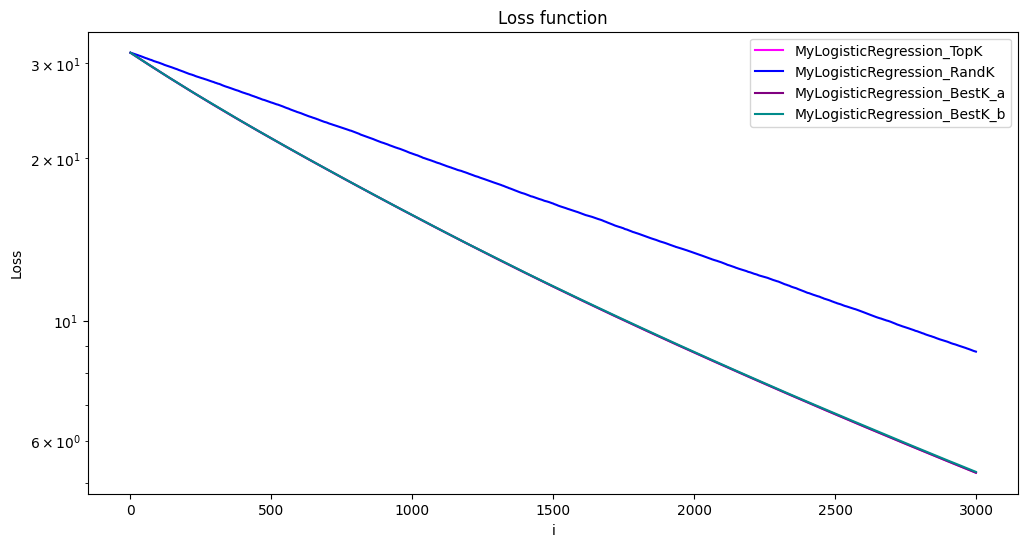

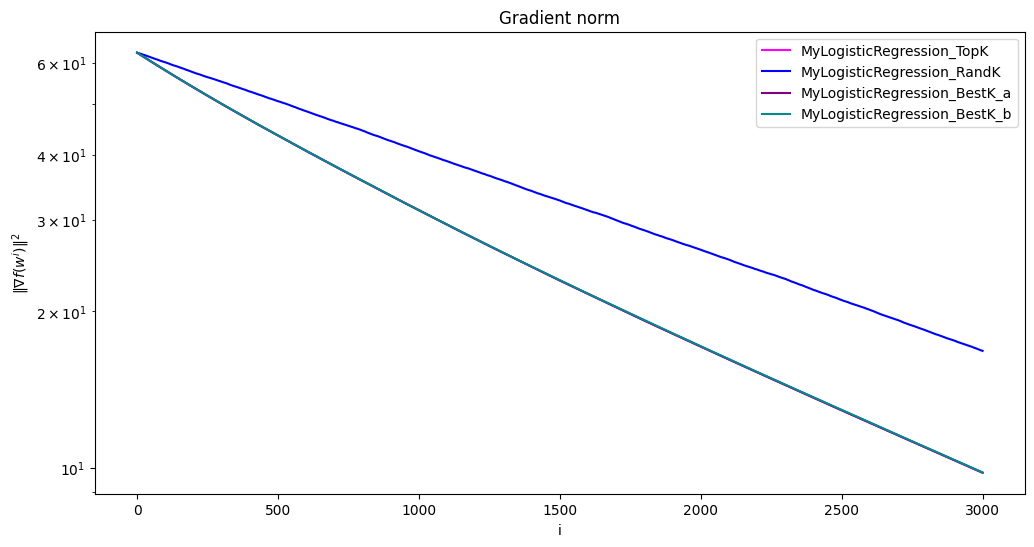

In [94]:
MAX_ITER = 3000
K = 5

MODEL_CLASS_LIST = [
    # MyLogisticRegression,
    MyLogisticRegression_TopK,
    MyLogisticRegression_RandK,
    MyLogisticRegression_BestK_a,
    MyLogisticRegression_BestK_b,
    MyLogisticRegression_BestK_c,
]

LABEL_LIST = [model.__name__ for model in MODEL_CLASS_LIST]

COLOR_LIST = [
    'magenta',
    'blue',
    'purple',
    'darkcyan',
    'orange',
    'green',
    'red',
    'pink',
]


LOSSES = dict()
GRADS = dict()


for (model_class, label, color) in zip(MODEL_CLASS_LIST, LABEL_LIST, COLOR_LIST):
    if label == 'MyLogisticRegression':
        model = model_class(max_iter=MAX_ITER)
    else:
        model = model_class(max_iter=MAX_ITER, K=K)

    model.fit(X_train, y_train, draw=False)
    
    w_history = model.coef_history_
    LOSSES[label] = []
    GRADS[label] = []
    for w in w_history:
        LOSSES[label].append(model._loss(w))
        GRADS[label].append(np.linalg.norm(model._gradient(w), 2) ** 2)
    print(f"{label}: Successfully done!")


plt.figure(figsize=(12, 6))
plt.title('Loss function')
for label, color in zip(LABEL_LIST, COLOR_LIST):
    plt.plot(LOSSES[label], color=color, label=label)
plt.xlabel('i')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend(loc='best')
plt.show()


plt.figure(figsize=(12, 6))
plt.title('Gradient norm')
for label, color in zip(LABEL_LIST, COLOR_LIST):
    plt.plot(GRADS[label], color=color, label=label)
plt.xlabel('i')
plt.ylabel('$\\| \\nabla f(w^i) \\|^2$')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

In [96]:
MAX_ITER = 10000
K = 20

MODEL_CLASS_LIST = [
    # MyLogisticRegression,
    MyLogisticRegression_TopK,
    MyLogisticRegression_RandK,
    MyLogisticRegression_BestK_a,
    MyLogisticRegression_BestK_b,
]

LABEL_LIST = [model.__name__ for model in MODEL_CLASS_LIST]

COLOR_LIST = [
    'magenta',
    'blue',
    'purple',
    'darkcyan',
    'orange',
    'green',
    'red',
    'pink',
]


LOSSES = dict()
GRADS = dict()


for (model_class, label, color) in zip(MODEL_CLASS_LIST, LABEL_LIST, COLOR_LIST):
    if label == 'MyLogisticRegression':
        model = model_class(max_iter=MAX_ITER)
    else:
        model = model_class(max_iter=MAX_ITER, K=K)

    model.fit(X_train, y_train, draw=False)
    
    w_history = model.coef_history_
    LOSSES[label] = []
    GRADS[label] = []
    for w in w_history:
        LOSSES[label].append(model._loss(w))
        GRADS[label].append(np.linalg.norm(model._gradient(w), 2) ** 2)
    print(f"{label}: Successfully done!")


plt.figure(figsize=(12, 6))
plt.title('Loss function')
for label, color in zip(LABEL_LIST, COLOR_LIST):
    plt.plot(LOSSES[label], color=color, label=label)
plt.xlabel('i')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend(loc='best')
plt.show()


plt.figure(figsize=(12, 6))
plt.title('Gradient norm')
for label, color in zip(LABEL_LIST, COLOR_LIST):
    plt.plot(GRADS[label], color=color, label=label)
plt.xlabel('i')
plt.ylabel('$\\| \\nabla f(w^i) \\|^2$')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

MyLogisticRegression_TopK: Successfully done!
MyLogisticRegression_RandK: Successfully done!
MyLogisticRegression_BestK_a: Successfully done!


KeyboardInterrupt: 